## Load In Libraries

In [1]:
import math
import ctREFPROP.ctREFPROP as ct
import os
import numpy as np
import matplotlib.pyplot as plt

# Hack for my installation
os.environ['RPPREFIX'] = r'C:\\Program Files (x86)\REFPROP'

root = os.environ['RPPREFIX']
#r = ct.REFPROPFunctionLibrary(os.path.join(root, 'refprop.dll'))
r = ct.REFPROPFunctionLibrary(os.path.join(root, 'REFPRP64.dll'))
r.SETPATHdll(root)

## Real Gas Data Generation

In [14]:



fuel_type='methane.FLD'
xf=0.3
x = xf

## Conditions
# for ethane
dP = 200 
Psweep = np.arange(100,9000+dP,dP)
dT = 2
Tsweep = np.arange(80,600+dT,dT)

# for methane
#dT = 0.5
#Tsweep = np.arange(130,165+dT,dT)
#dP = 10
#Psweep = np.arange(4000,5000+dP,dP)

Rho = np.zeros(Psweep.size*Tsweep.size)
Pall = np.zeros(Psweep.size*Tsweep.size)
Tall = np.zeros(Psweep.size*Tsweep.size)
T_sat_V = np.zeros(Psweep.size)
T_sat_L = np.zeros(Psweep.size)


Ru = 8.314



chamberAmb = 'nitrogen.FLD'
amb_type='nitrogen.FLD'
mix_list=fuel_type+"|"+amb_type
ierr, herr = r.GERG08dll(2,0)
if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)

r.FLAGSdll('GERG',1)
ierr, herr = r.SETUPdll(2,mix_list,'HMX.BNC','DEF')
if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)

    
if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)
    
zf=[1,0]
zamb=[0,1]


MWf = r.WMOLdll(zf)
MWamb = r.WMOLdll(zamb)

kk = -1
jj=-1
for P in Psweep:
    z=[x,(1-x)]
    jj+=1
    for T in Tsweep:
        kk+=1

        ## Inlet Conditions
        
        Props = r.TPFLSHdll(T,P,z)
        MW = r.WMOLdll(z)
        

        if Props.ierr==0:
            Rho[kk] = Props.D*MW
            Tall[kk] = T
            Pall[kk] = P
        else:
            Rho[kk] = None
            

    print('%d / %d'%(jj, Psweep.size-1),end='\r')

## Cricondentherm/bar points

In [15]:

iUnits = 0 # in kPa
iMass = 0
iFlag = 1
T = 0
D = 0


ierr, herr = r.SATSPLNdll(z)   
ALL = r.ALLPROPSdll('TMAXT',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondentherm_T = Cri

ALL = r.ALLPROPSdll('PMAXT',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondentherm_P = Cri

ALL = r.ALLPROPSdll('PMAXP',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondenbar_P = Cri

ALL = r.ALLPROPSdll('TMAXP',iUnits,iMass,iFlag,T,D,z)
SubALL = ALL[0]
Cri = SubALL[0]
Cricondenbar_T = Cri

CriticalProp = r.CRTPNTdll(z,0,0)
if CriticalProp.ierr == 0:
    CP_T = CriticalProp.Tc
    CP_P = CriticalProp.Pc
    

## For Ethane

In [4]:
dP = 10
Psweep2 = np.arange(100,9000+dP,dP)


T_sat_V = np.zeros(Psweep2.size)
T_sat_L = np.zeros(Psweep2.size)
jj=-1
for P in Psweep2:
    jj+=1
    satprops = r.SATPdll(P,z,2)
    if satprops.ierr ==0:
        T_sat_V[jj] = satprops.T
        
        if T_sat_V[jj]<100:
            T_sat_V[jj] = None  
    else:
        T_sat_V[jj] = None
    satprops = r.SATPdll(P,z,1)
    if satprops.ierr ==0:
        T_sat_L[jj] = satprops.T
        if T_sat_L[jj]<101:
            T_sat_L[jj] = None
    else:
        T_sat_L[jj] = None
    print('%d / %d'%(jj, Psweep2.size-1),end='\r')

## For methane

In [16]:
dP = 1
Psweep2 = np.arange(4000,Cricondenbar_P+dP,dP)

T_sat_V = np.zeros(Psweep2.size)
T_sat_L = np.zeros(Psweep2.size)
jj=-1
for P in Psweep2:
    jj+=1
    satprops = r.SATPdll(P,z,2)
    if satprops.ierr ==0:
        T_sat_V[jj] = satprops.T
        

        if T_sat_V[jj]<Cricondenbar_T:
            T_sat_V[jj] = None    
    else:
        T_sat_V[jj] = None
    satprops = r.SATPdll(P,z,1)
    if satprops.ierr ==0:
        T_sat_L[jj] = satprops.T
        if T_sat_L[jj]<101:
            T_sat_L[jj] = None
        if T_sat_L[jj]>147.5:
            T_sat_L[jj] = None    
    else:
        T_sat_L[jj] = None
    print('%d / %d'%(jj, Psweep2.size-1),end='\r')
T_sat_V[-1] = Cricondenbar_T
T_sat_L[-1] = Cricondenbar_T


In [17]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

a = pd.Series(Rho)
i=-1
while i<4:
    i+=1
    aint = a.interpolate(method="linear")
    Rho2 = aint.to_numpy()
    Rho2
    Rho3 = savgol_filter(Rho2, 5, 1)
np.count_nonzero(np.isnan(Rho2))

0

## Contour Plot of Density of Ethane-N2

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


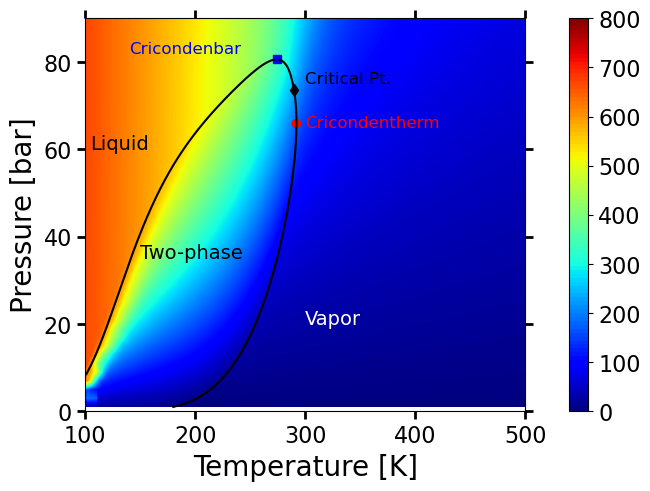

In [13]:
import scipy.ndimage
X, Y = np.meshgrid(Tsweep, Psweep/100)
Rhogrid = np.reshape(Rho3, (Psweep.size,Tsweep.size))
RhoSmooth = scipy.ndimage.zoom(Rhogrid, 1)
XSmooth = scipy.ndimage.zoom(X, 1)
YSmooth = scipy.ndimage.zoom(Y, 1)
fig, ax = plt.subplots(constrained_layout=True)




vmin = 0
vmax=800


from matplotlib.cm import ScalarMappable
levels = 100

level_boundaries = np.linspace(vmin, vmax, levels + 1)

quadcontourset = ax.contourf(
    X, Y, Rhogrid, 1000, cmap='jet',  # change this to `levels` to get the result that you want
    vmin=vmin, vmax=vmax
)


fig.colorbar(
    ScalarMappable(norm=quadcontourset.norm, cmap=quadcontourset.cmap),
    ticks=range(vmin, vmax+5, 100),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
)


plt.ylim([0, 90])
plt.xlim([100, 500])
plt.ylabel('Pressure [bar]')
plt.xlabel('Temperature [K]')
ax.set_xticks(np.linspace(100, 500, 5))
ax.set_xticklabels(['100', '200', '300', '400', '500'])
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
font = {'family' : 'normal',
        'weight' : 'normal'}
ax.tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5,right='bool',top='bool')
plt.rc('font', **font)
plt.plot(CP_T,CP_P/100,'kd','LineWidth',10)
plt.plot(Cricondenbar_T,Cricondenbar_P/100,'bs','LineWidth',2)
plt.plot(Cricondentherm_T,Cricondentherm_P/100,'ro','LineWidth',2)
plt.plot(T_sat_L,Psweep2/100,'k','LineWidth',2)
plt.plot(T_sat_V,Psweep2/100,'k','LineWidth',2)
plt.text(300,20,'Vapor',fontsize=14, color='w')
plt.text(105,60,'Liquid',fontsize=14, color='k')
plt.text(150,35,'Two-phase',fontsize=14, color='k')
plt.text(140,82,'Cricondenbar',fontsize=12, color='b')
plt.text(300,65,'Cricondentherm',fontsize=12, color='r')
plt.text(300,75,'Critical Pt.',fontsize=12, color='k')
plt.show()





In [45]:
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'Ethane_n2_contour.eps'

fig.savefig(image_name, format=image_format, dpi=1200)

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

a = pd.Series(T_sat_V)
i=-1
while i<4:
    i+=1
    aint = a.interpolate(method="linear")
    T_sat_V2 = aint.to_numpy()
    T_sat_V3 = savgol_filter(T_sat_V2, 51, 5)
np.count_nonzero(np.isnan(T_sat_V2))


a = pd.Series(T_sat_L)
i=-1
while i<4:
    i+=1
    aint = a.interpolate(method="polynomial", order=3)
    T_sat_L2 = aint.to_numpy()
    T_sat_L3 = savgol_filter(T_sat_L2, 51, 5)
np.count_nonzero(np.isnan(T_sat_L2))

## Contour Plot of Density for Methane-N2

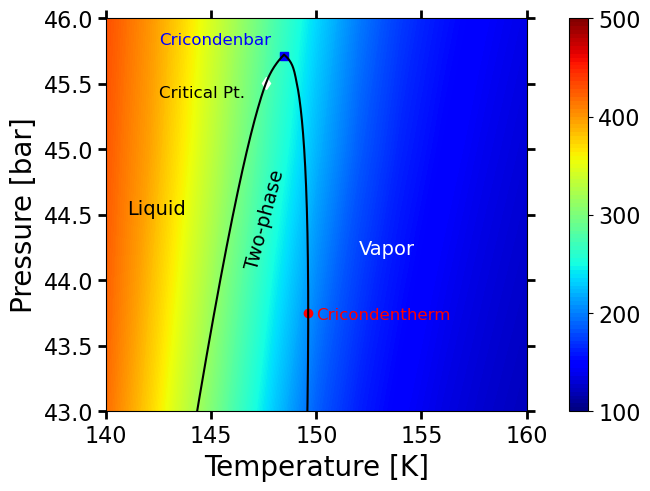

In [20]:
import scipy.ndimage
X, Y = np.meshgrid(Tsweep, Psweep/100)
Rhogrid = np.reshape(Rho3, (Psweep.size,Tsweep.size))
RhoSmooth = scipy.ndimage.zoom(Rhogrid, 1)
XSmooth = scipy.ndimage.zoom(X, 1)
YSmooth = scipy.ndimage.zoom(Y, 1)
fig, ax = plt.subplots(constrained_layout=True)



vmin = 100
vmax=500


from matplotlib.cm import ScalarMappable
levels = 100

level_boundaries = np.linspace(vmin, vmax, levels + 1)

quadcontourset = ax.contourf(
    X, Y, Rhogrid, 1000, cmap='jet',  # change this to `levels` to get the result that you want
    vmin=vmin, vmax=vmax
)


fig.colorbar(
    ScalarMappable(norm=quadcontourset.norm, cmap=quadcontourset.cmap),
    ticks=range(vmin, vmax+5, 100),
    boundaries=level_boundaries,
    values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
)

#ax.set_ylabel('Density [kg/m$^3$]', fontweight="normal");
#cbar.set_ticks(np.linspace(0, 800, 9))
#cbar.set_ticklabels([0, 100, 200, 300, 400, 500, 600, 700, 800])

plt.ylim([43, 46])
plt.xlim([140, 160])
plt.ylabel('Pressure [bar]')
plt.xlabel('Temperature [K]')
ax.set_xticks(np.linspace(140, 160, 5))
ax.set_xticklabels(['140', '145', '150', '155', '160'])
SMALL_SIZE = 8
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
font = {'family' : 'normal',
        'weight' : 'normal'}
ax.tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5,right='bool',top='bool')
plt.rc('font', **font)
#plt.hold(True)
#plt.plot(CP_T_2,CP_P_2/100,'bx','LineWidth',3)
plt.plot(CP_T,CP_P/100,'wd','LineWidth',10)
plt.plot(Cricondenbar_T,Cricondenbar_P/100,'bs','LineWidth',2)
plt.plot(Cricondentherm_T,Cricondentherm_P/100,'ro','LineWidth',2)
#plt.legend(["Cricondenbar", "Cricondentherm", "Critical Pt"], loc ="upper right",frameon=False,fontsize=10,labelcolor='w')
plt.plot(T_sat_L3,Psweep2/100,'k','LineWidth',2)
plt.plot(T_sat_V3,Psweep2/100,'k','LineWidth',2)
plt.text(152,44.2,'Vapor',fontsize=14, color='w')
plt.text(141,44.5,'Liquid',fontsize=14, color='k')
plt.text(146.5,44.1,'Two-phase',fontsize=14, color='k',rotation=75)
plt.text(142.5,45.8,'Cricondenbar',fontsize=12, color='b')
plt.text(150,43.7,'Cricondentherm',fontsize=12, color='r')
plt.text(142.5,45.4,'Critical Pt.',fontsize=12, color='k')
plt.show()





In [373]:
image_format = 'eps' # e.g .png, .svg, etc.
image_name = 'Methane_n2_contour.eps'

fig.savefig(image_name, format=image_format, dpi=1200)